# Digital Filters, TOF calculation

In [14]:
import numpy as np
import scipy.signal
from scipy import signal
from matplotlib import pyplot as plt
from scipy.signal import firwin
from scipy.signal import find_peaks, convolve

### Digital filtering for noise reduction

In [3]:
class DigitalFilter:
    
    def __init__(self, filter_type, filter_params):
        self.filter_type = filter_type
        self.filter_params = filter_params
        
    def apply_filter(self, signal_data):
        if self.filter_type == "low_pass_fir":
            return self._apply_low_pass_fir(signal_data, **self.filter_params)
        elif self.filter_type == "savitzky_golay":
            return self._apply_savitzky_golay(signal_data, **self.filter_params)
        elif self.filter_type == "moving_average":
            return self._apply_moving_average(signal_data, **self.filter_params)
        elif self.filter_type == "anti_aliasing":
            return self._apply_anti_aliasing(signal_data, **self.filter_params)
        else:
            raise ValueError("Invalid filter type")
    
    def _apply_low_pass_fir(self, signal_data, cutoff_freq, filter_length):
        nyquist_freq = 0.5 * signal_data.size
        fir_coeff = signal.firwin(filter_length, cutoff_freq / nyquist_freq)
        return signal.convolve(signal_data, fir_coeff, mode="same")
    
    def _apply_savitzky_golay(self, signal_data, window_size, order):
        return signal.savgol_filter(signal_data, window_size, order)
    
    def _apply_moving_average(self, signal_data, window_size):
        return np.convolve(signal_data, np.ones(window_size)/window_size, mode="same")
    
    def _apply_anti_aliasing(self, signal_data, cutoff_freq):
        nyquist_freq = 0.5 * signal_data.size
        b, a = signal.butter(4, cutoff_freq / nyquist_freq, btype="low")
        return signal.filtfilt(b, a, signal_data)


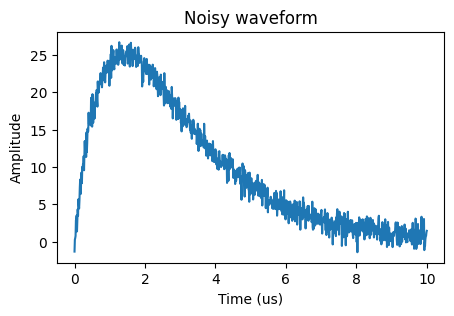

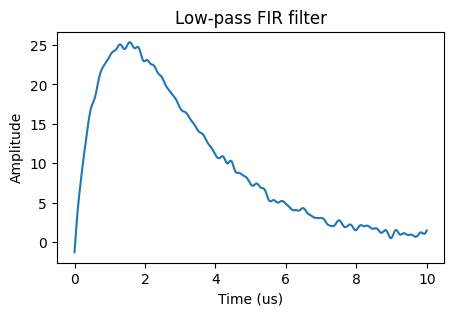

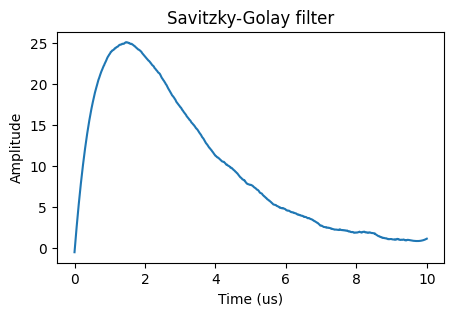

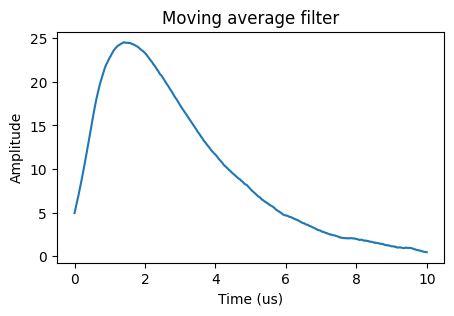

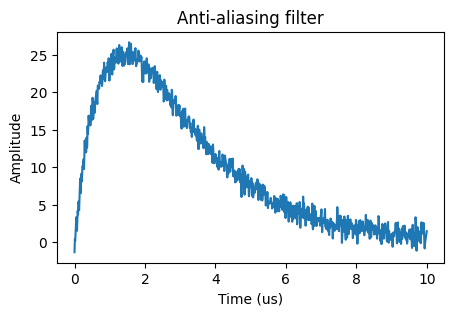

In [8]:

# Generate noisy waveform similar to plastic scintillator with SiPM
fs = 100e6  # digitizer sampling rate
t = np.arange(0, 10e-6, 1 / fs)  # 10 us acquisition time
noise = np.random.normal(0, 1, len(t))  # white noise
sig = 100 * np.exp(-t / 2e-6) * (1 - np.exp(-t / 2e-6))  # scintillation pulse
waveform = sig + noise

# Plot original waveform
plt.figure(figsize=(5, 3))
plt.plot(t * 1e6, waveform)
plt.xlabel('Time (us)')
plt.ylabel('Amplitude')
plt.title('Noisy waveform')

# Apply low-pass FIR filter
cutoff = 5e6  # 5 MHz cutoff frequency
taps = 101  # filter length
b = signal.firwin(taps, cutoff / fs * 2)
filtered_waveform = signal.filtfilt(b, 1, waveform)

# Plot filtered waveform
plt.figure(figsize=(5, 3))
plt.plot(t * 1e6, filtered_waveform)
plt.xlabel('Time (us)')
plt.ylabel('Amplitude')
plt.title('Low-pass FIR filter')

# Apply Savitzky-Golay filter
window_length = 101  # filter window length
poly_order = 3  # polynomial order
filtered_waveform = signal.savgol_filter(waveform, window_length, poly_order)

# Plot filtered waveform
plt.figure(figsize=(5, 3))
plt.plot(t * 1e6, filtered_waveform)
plt.xlabel('Time (us)')
plt.ylabel('Amplitude')
plt.title('Savitzky-Golay filter')

# Apply moving average filter
window_length = 101  # filter window length
filtered_waveform = np.convolve(waveform, np.ones(window_length) / window_length, mode='same')

# Plot filtered waveform
plt.figure(figsize=(5, 3))
plt.plot(t * 1e6, filtered_waveform)
plt.xlabel('Time (us)')
plt.ylabel('Amplitude')
plt.title('Moving average filter')

# Apply anti-aliasing filter
cutoff = 40e6  # 40 MHz cutoff frequency
order = 5  # filter order
b, a = signal.butter(order, cutoff / (fs / 2), btype='lowpass')
filtered_waveform = signal.filtfilt(b, a, waveform)

# Plot filtered waveform
plt.figure(figsize=(5, 3))
plt.plot(t * 1e6, filtered_waveform)
plt.xlabel('Time (us)')
plt.ylabel('Amplitude')
plt.title('Anti-aliasing filter')
plt.show()

### TOF calculation

Text(0.5, 0, 'Samples at 100 MHz')

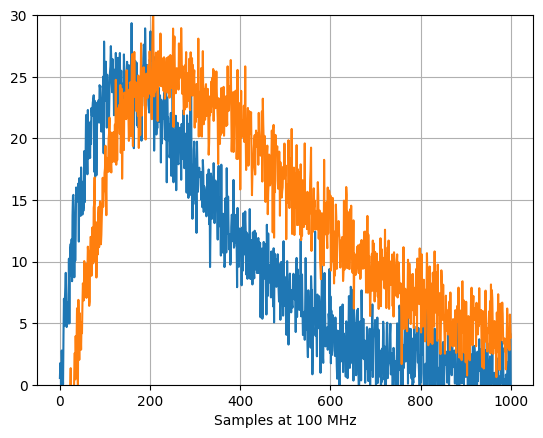

In [79]:
fs = 100e6  # digitizer sampling rate
t = np.arange(0, 10e-6, 1 / fs)  # 10 us acquisition time
noise1 = np.random.normal(0, 1, len(t)) * 2  # white noise
noise2 = np.random.normal(0, 1, len(t)) * 2  # white noise
t1 = t + 0
t2 = t - 300e-9
sig1 = 100 * np.exp(-(t1 ) / 2e-6) * (1 - np.exp(-t1 / 2e-6))  # scintillation 1 pulse
sig2 = 100 * np.exp(-(t2 ) / 3e-6) * (1 - np.exp(-t2 / 3e-6))  # scintillation 2 pulse
waveform1 = sig1 + noise1
waveform2 = sig2 + noise2
plt.ylim(0, 30)
plt.plot(waveform1)
plt.plot(waveform2)
plt.grid()
plt.xlabel("Samples at 100 MHz")

Time difference between peaks: -690.0  ns


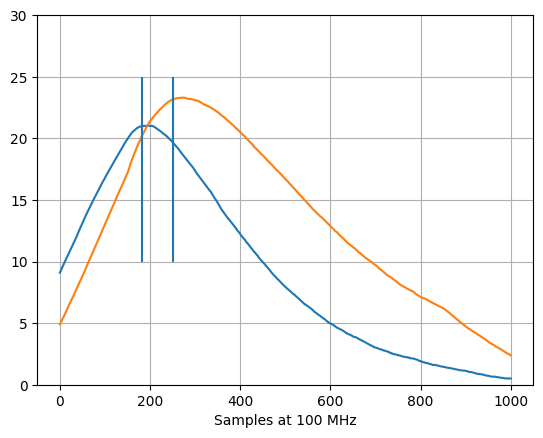

In [83]:
# Apply a moving average filter to each signal
window_size = 300
filter1 = np.ones(window_size) / window_size
filter2 = np.ones(window_size) / window_size

filtered_signal1 = signal.convolve(waveform1, filter1, mode='same')
filtered_signal2 = signal.convolve(waveform2, filter2, mode='same')

# Find the peaks of each signal
peaks1, _ = find_peaks(filtered_signal1)
peaks2, _ = find_peaks(filtered_signal2)

# Calculate the time difference between the peaks
if len(peaks1) > 0 and len(peaks2) > 0:
    time_difference = peaks1[0] - peaks2[0]
    print("Time difference between peaks:", time_difference * 1./fs * 1e9, " ns")
else:
    print("No peaks detected")

plt.ylim(0, 30)
plt.plot(filtered_signal1)
plt.plot(filtered_signal2)
plt.grid()
plt.xlabel("Samples at 100 MHz")
plt.vlines(peaks1[0], 10, 25)
plt.vlines(peaks2[0], 10, 25)

### TO BE FIXED